Install Dependencies

In [ ]:
# -*- coding: utf-8 -*-
# Install all required libraries quietly
!pip install ipywidgets transformers torch sentencepiece huggingface_hub pypdf evaluate scikit-learn sentence-transformers matplotlib seaborn pandas nltk textstat rouge_score --quiet
# accelerate is needed for efficient multi-device model loading
!pip install accelerate --quiet
print(" All dependencies installed successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.3 MB/s eta 0:00:00
 All dependencies installed successfully.


Import Libraries & Authenticate

In [ ]:
import os
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata
from huggingface_hub import login
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import numpy as np
import pypdf
import evaluate
import nltk
import io
import warnings
import time
import textstat
from math import pi

# --- 0. SETUP AND AUTHENTICATION ---
warnings.filterwarnings("ignore")

# CORRECTED: Download the 'punkt' resource and the specific 'punkt_tab' to fix the TextRank error
try:
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab', quiet=True) # <-- This line explicitly fixes the error
except Exception as e:
    print(f"Error downloading NLTK data: {e}")

# Securely get the token from Colab secrets
try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    login(token=HF_TOKEN)
    print(" Hugging Face Hub login successful.")
except Exception as e:
    print(f"Hugging Face Hub login failed. Please ensure you have set the 'HF_TOKEN' secret correctly.")
    print(f"Error: {e}")

 Hugging Face Hub login successful.


 Load AI Models

In [ ]:
# Install the evaluate library and rouge_score
!pip install evaluate rouge_score --quiet

import torch # Import the torch library
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline # Import necessary classes from transformers
from sentence_transformers import SentenceTransformer # Import SentenceTransformer
import evaluate # Import the evaluate library

# --- 1. LOAD MODELS (PRE-COMPUTATION) ---
print("Loading small, fast models... This should be quicker now. ⏳")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Model Dictionary to hold all loaded models
MODELS = {}

try:
    # Model 1: TinyLlama-1.1B-Chat (Open, 1.1B)
    model_id_tiny = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
    MODELS['tinyllama'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_tiny),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_tiny,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        ),
        'name': "TinyLlama-1.1B-Chat"
    }
    print("Loaded TinyLlama-1.1B-Chat.")

    # Model 2: Phi-1.5 (Restricted License, 1.3B)
    model_id_phi = "microsoft/phi-1.5"
    MODELS['phi'] = {
        'tokenizer': AutoTokenizer.from_pretrained(model_id_phi, trust_remote_code=True),
        'model': AutoModelForCausalLM.from_pretrained(
            model_id_phi,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        ),
        'name': "Phi-1.5"
    }
    print("Loaded Phi-1.5.")

    # Model 3: BART (Public Baseline, ~400M)
    model_id_bart = "facebook/bart-large-cnn"
    MODELS['bart'] = {
        'summarizer': pipeline("summarization", model=model_id_bart, device=0 if device=="cuda" else -1),
        'name': 'BART-Large-CNN'
    }
    print(" Loaded BART-Large-CNN.")

    # Model 4: Sentence Transformer (for Extractive Baseline)
    MODELS['embedding'] = {
        'model': SentenceTransformer('all-MiniLM-L6-v2', device=device),
        'name': 'TextRank (Embeddings)'
    }
    print("Loaded Sentence Transformer for TextRank.")

    print("\nAll models loaded successfully!")
except Exception as e:
    print(f"Error loading models: {e}. Please check your token and model access permissions.")
    # Removed exit() so the cell doesn't stop execution completely
    # exit()

rouge_metric = evaluate.load("rouge")

  Preparing metadata (setup.py) ... done
Loading small, fast models... This should be quicker now. ⏳
Using device: cuda
Loaded TinyLlama-1.1B-Chat.
Loaded Phi-1.5.


Device set to use cuda:0


 Loaded BART-Large-CNN.
Loaded Sentence Transformer for TextRank.

All models loaded successfully!


In [ ]:
!pip install evaluate rouge_score --quiet
print("evaluate and rouge_score installed.")

evaluate and rouge_score installed.


Abstractive Summarization

TinyLlama

In [ ]:
# --- INSTALL ---
# !pip install transformers torch

# --- IMPORTS ---
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# --- LOAD MODEL ---
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# --- FUNCTION ---
def summarize_tinyllama(text):
    chat = [{"role": "user", "content": f"Summarize this text concisely:\n\n{text}"}]
    prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=200)
    return tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):], skip_special_tokens=True)

# --- SAMPLE TEXT ---
text = """
Infosys TextMorph Milestone 2 focuses on advanced text summarization (both abstractive and extractive),
evaluation using ROUGE metrics, interactive Google Colab UIs, testing on 10+ domain-specific texts,
and visualizing performance through comparative plots.
"""

# --- RUN ---
summary = summarize_tinyllama(text)
print("TinyLlama Summary:\n", summary)


TinyLlama Summary:
 Infosys TextMorph Milestone 2 focuses on advanced text summarization using both abstractive and extractive approaches, evaluation using ROUGE metrics, interactive Google Colab UIs, and testing on 10+ domain-specific texts. The milestone also includes visualizing performance through comparative plots.


Phi (microsoft/phi-2)

In [ ]:
# --- INSTALL ---
# !pip install transformers torch

# --- IMPORTS ---
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# --- LOAD MODEL ---
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# --- FUNCTION ---
def summarize_phi(text):
    prompt = f"Instruct: Summarize the following text concisely.\n{text}\nOutput:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=200)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if "Output:" in decoded:
        return decoded.split("Output:")[1].strip()
    return decoded

# --- SAMPLE TEXT ---
text = """
The Infosys TextMorph program milestone emphasizes abstractive and extractive summarization models,
metric-based evaluation, UI creation in Google Colab, testing on various domains, and visualization of outcomes.
"""

# --- RUN ---
summary = summarize_phi(text)
print(" Phi Summary:\n", summary)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Phi Summary:
 The Infosys TextMorph program milestone highlights the development of abstractive and extractive summarization models, metric-based evaluation, UI creation in Google Colab, testing on different domains, and visualization of outcomes.


BART-large-cnn

In [ ]:

from transformers import BartTokenizer, BartForConditionalGeneration

# --- LOAD MODEL ---
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# --- FUNCTION ---
def summarize_bart(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=120,
        min_length=40,
        num_beams=4,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# --- SAMPLE TEXT ---
text = """
Milestone 2 of Infosys TextMorph aims to advance summarization through modern transformer models,
evaluate them with standardized metrics, and provide a user-friendly interactive platform
to visualize results across multiple domains.
"""

# --- RUN ---
summary = summarize_bart(text)
print("BART Summary:\n", summary)


BART Summary:
 Milestone 2 of Infosys TextMorph aims to advance summarization through modern transformer models,evaluate them with standardized metrics, and provide a user-friendly interactive platform to visualize results across multiple domains.


Gemma (google/gemma-2b-it)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# --- LOAD MODEL ---
model_name = "google/gemma-2b-it"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.bfloat16
)

# --- FUNCTION ---
def summarize_gemma(text):
    prompt = f"Summarize the following text concisely and clearly:\n\n{text}"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=200)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- SAMPLE TEXT ---
text = """
Infosys TextMorph Milestone 2 focuses on implementing abstractive summarization models like TinyLlama, Phi, BART, and Gemma,
evaluating their performance through metrics and readability, and integrating them into an interactive Colab UI for visualization.
"""

# --- RUN ---
summary = summarize_gemma(text)
print("Gemma Summary:\n", summary)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Gemma Summary:
 Summarize the following text concisely and clearly:


Infosys TextMorph Milestone 2 focuses on implementing abstractive summarization models like TinyLlama, Phi, BART, and Gemma,
evaluating their performance through metrics and readability, and integrating them into an interactive Colab UI for visualization.
The project aims to explore the potential of these models for text generation, summarization, and information extraction.


TextRank – Extractive Summarization

In [ ]:
# --- INSTALL ---
!pip install summa --quiet

from summa import summarizer

# --- FUNCTION ---
def summarize_textrank(text, num_sentences=3):
    """
    Perform extractive summarization using TextRank from the summa library.
    Extracts approximately 'num_sentences' most important sentences from the text.
    """
    # Get list of important sentences
    summarized_sentences = summarizer.summarize(text, ratio=0.3, split=True)

    # Select the top N sentences
    top_sentences = summarized_sentences[:num_sentences]

    # Join them into one string
    return "\n".join(top_sentences)


# --- SAMPLE TEXT ---
text = """
The Infosys TextMorph Milestone 2 focuses on advanced text summarization methods,
including both abstractive and extractive techniques. Interns are expected to evaluate models
using metrics like ROUGE and semantic similarity. The milestone also requires building
interactive Google Colab UIs, testing on more than 10 sample texts from various domains,
and visualizing the model performance through comparative plots such as bar and radar charts.
"""

# --- RUN ---
summary = summarize_textrank(text, num_sentences=3)
print("TextRank Extractive Summary:\n")
print(summary)


TextRank Extractive Summary:

The Infosys TextMorph Milestone 2 focuses on advanced text summarization methods,
The milestone also requires building


Evaluation Metrics Code

In [ ]:
# Install required libraries
!pip install rouge-score sentence-transformers textstat nltk

#  Import libraries
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer, util
import textstat
import nltk

nltk.download('punkt')

# Example ground truth and generated summaries
reference_summary = """Artificial Intelligence is a branch of computer science that enables machines to mimic human intelligence, including learning and decision-making."""
generated_summary = """AI is a field in computer science that helps machines learn and make human-like decisions."""

# -------------------------------
# 🔹 1. ROUGE SCORE EVALUATION
# -------------------------------
def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    print("\n ROUGE Scores:")
    for metric, result in scores.items():
        print(f"{metric.upper()} -> Precision: {result.precision:.4f}, Recall: {result.recall:.4f}, F1: {result.fmeasure:.4f}")
    return scores

rouge_scores = calculate_rouge(reference_summary, generated_summary)

# -------------------------------
# 🔹 2. SEMANTIC SIMILARITY
# -------------------------------
def calculate_semantic_similarity(reference, generated):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings1 = model.encode(reference, convert_to_tensor=True)
    embeddings2 = model.encode(generated, convert_to_tensor=True)
    similarity = util.cos_sim(embeddings1, embeddings2)
    print(f"\n Semantic Similarity: {similarity.item():.4f}")
    return similarity.item()

semantic_score = calculate_semantic_similarity(reference_summary, generated_summary)

# -------------------------------
# 🔹 3. READABILITY METRICS
# -------------------------------
def calculate_readability(text):
    print("\n Readability Metrics:")
    print(f"Flesch Reading Ease: {textstat.flesch_reading_ease(text):.2f}")
    print(f"Flesch-Kincaid Grade Level: {textstat.flesch_kincaid_grade(text):.2f}")
    print(f"SMOG Index: {textstat.smog_index(text):.2f}")
    print(f"Automated Readability Index: {textstat.automated_readability_index(text):.2f}")

calculate_readability(generated_summary)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.



 ROUGE Scores:
ROUGE1 -> Precision: 0.6875, Recall: 0.5500, F1: 0.6111
ROUGE2 -> Precision: 0.2667, Recall: 0.2105, F1: 0.2353
ROUGEL -> Precision: 0.5625, Recall: 0.4500, F1: 0.5000

 Semantic Similarity: 0.8526

 Readability Metrics:
Flesch Reading Ease: 61.89
Flesch-Kincaid Grade Level: 8.35
SMOG Index: 13.02
Automated Readability Index: 9.93


UI AND UX


In [ ]:
# Step 1: Setup
!pip install gradio transformers sentencepiece --quiet

from transformers import pipeline
import gradio as gr

# Load model (you can change to TinyLlama, Pegasus, or T5)
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

print("✅ Model loaded successfully and ready for UI!")


Device set to use cuda:0


✅ Model loaded successfully and ready for UI!


 UI/UX Interaction Code

In [ ]:
# ------------------ UI 1 ------------------
import ipywidgets as widgets # Import ipywidgets
from IPython.display import display, clear_output # Import display and clear_output

stext_input_all = widgets.Textarea(
    value="",
    placeholder="Paste your text here...",
    description="Input:",
    layout=widgets.Layout(width="100%", height="150px")
)

btn_summarize_all = widgets.Button(description="Summarize with All Models", button_style="success")
output_all = widgets.Output()

def summarize_all_models(b):
    with output_all:
        clear_output()
        text = stext_input_all.value.strip()
        if not text:
            print(" Please enter some text!")
            return

        print(" Generating summaries...\n")

        models = {
            "BART": pipeline("summarization", model="facebook/bart-large-cnn"),
            "TinyLlama": pipeline("summarization", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0"),
            "Phi": pipeline("summarization", model="bigscience/phi-1.0"),
            "Gemma": pipeline("summarization", model="google/gemma-2b-it"),
            "TextRank": "textrank"
        }

        for name, model in models.items():
            print(f" Model: {name}")
            if name == "TextRank":
                # Assuming textrank_summarizer is defined in a previous cell
                summary = textrank_summarizer.summarize(text)
            else:
                summary = model(text, max_length=120, min_length=40, do_sample=False)[0]['summary_text']

            readability = textstat.flesch_reading_ease(summary)
            compression = round((1 - len(summary)/len(text))*100, 2)

            print(f"Summary:\n{summary}")
            print(f"Readability Score: {readability}")
            print(f"Compression: {compression}%\n")
            print("-"*60)

btn_summarize_all.on_click(summarize_all_models)

display(widgets.VBox([stext_input_all, btn_summarize_all, output_all]))

Summarize with Selected Models

In [ ]:
# ------------------ UI 2 ------------------
stext_input_sel = widgets.Textarea(
    value="",
    placeholder="Paste your text here...",
    description="Input:",
    layout=widgets.Layout(width="100%", height="150px")
)

# Checkbox selection for models
model_checkboxes = widgets.VBox([
    widgets.Checkbox(value=True, description='BART'),
    widgets.Checkbox(value=True, description='TinyLlama'),
    widgets.Checkbox(value=True, description='Phi'),
    widgets.Checkbox(value=True, description='Gemma'),
    widgets.Checkbox(value=True, description='TextRank')
])

btn_summarize_sel = widgets.Button(description="Summarize Selected Models", button_style="info")
output_sel = widgets.Output()

def summarize_selected_models(b):
    with output_sel:
        clear_output()
        text = stext_input_sel.value.strip()
        if not text:
            print("Please enter some text!")
            return

        selected_models = [cb.description for cb in model_checkboxes.children if cb.value]
        if not selected_models:
            print("Please select at least one model!")
            return

        print(" Generating summaries...\n")

        model_pipelines = {
            "BART": pipeline("summarization", model="facebook/bart-large-cnn"),
            "TinyLlama": pipeline("summarization", model="TinyLlama/TinyLlama-1.1B-Chat-v1.0"),
            "Phi": pipeline("summarization", model="bigscience/phi-1.0"),
            "Gemma": pipeline("summarization", model="google/gemma-2b-it"),
            "TextRank": "textrank"
        }

        for name in selected_models:
            print(f"📌 Model: {name}")
            model = model_pipelines[name]
            if name == "TextRank":
                summary = textrank_summarizer.summarize(text)
            else:
                summary = model(text, max_length=120, min_length=40, do_sample=False)[0]['summary_text']

            readability = textstat.flesch_reading_ease(summary)
            compression = round((1 - len(summary)/len(text))*100, 2)

            print(f"Summary:\n{summary}")
            print(f"Readability Score: {readability}")
            print(f"Compression: {compression}%\n")
            print("-"*60)

btn_summarize_sel.on_click(summarize_selected_models)

display(widgets.VBox([stext_input_sel, model_checkboxes, btn_summarize_sel, output_sel]))


Test using 10 sample texts from different domains

In [ ]:
!pip install transformers sentencepiece textstat rouge-score summa --quiet

from transformers import pipeline
import textstat
import ipywidgets as widgets
from IPython.display import display, clear_output
from summa import summarizer as textrank_summarizer


In [ ]:
# --- INSTALL LIBRARIES ---
!pip install transformers rouge-score textstat sentence-transformers summa -q

# --- IMPORTS ---
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
import textstat
import nltk
import time
import pandas as pd

nltk.download('punkt', quiet=True) # Download punkt for textstat and summa

# --- SAMPLE TEXTS ---
sample_texts = {
    "Finance": "The Indian stock market surged today as banking and IT stocks led the rally. The Sensex rose by 450 points, closing above 67,000, while Nifty crossed 20,000. Analysts attribute the rally to strong quarterly earnings and robust GDP growth forecasts.",
    "Sports": "Virat Kohli scored a magnificent century leading India to victory against Australia in the final ODI match. The win secured India’s top position in the ICC rankings.",
    "Technology": "Google unveiled its latest AI model that integrates multimodal learning, combining text, image, and audio processing for improved contextual understanding."
}

# Ensure MODELS dictionary is available from a previous cell
if 'MODELS' not in globals():
    print("Error: MODELS dictionary not found. Please run the 'Load AI Models' cell first.")
    # Add a mechanism to stop execution if MODELS is not available
    # raise SystemExit("Required MODELS dictionary not found.")

# Access loaded models from the MODELS dictionary
bart_pipeline = MODELS.get('bart', {}).get('summarizer')
tinyllama_model_info = MODELS.get('tinyllama')
phi_model_info = MODELS.get('phi')
gemma_model_info = MODELS.get('gemma')

# TextRank (Extractive) using summa
from summa import summarizer as summa_textrank_summarizer

def textrank_summarize_summa(text, ratio=0.3):
    """
    Perform extractive summarization using TextRank from the summa library.
    """
    try:
        summary = summa_textrank_summarizer.summarize(text, ratio=ratio)
        if not summary.strip(): # Check for empty summary
             return "Error: TextRank produced an empty summary."
        return summary
    except Exception as e:
        print(f"TextRank summarization failed: {e}")
        return f"Error: TextRank summarization failed: {e}"

# --- EVALUATION FUNCTIONS ---
# Ensure sentence_model and rouge_scorer are initialized (assuming they are in a previous cell)
if 'sentence_model' not in globals():
    try:
        sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        print("SentenceTransformer loaded for evaluation.")
    except Exception as e:
        print(f"Error loading SentenceTransformer: {e}")
        sentence_model = None # Set to None if loading fails

if 'scorer' not in globals():
     try:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        print("ROUGE scorer initialized for evaluation.")
     except Exception as e:
        print(f"Error initializing ROUGE scorer: {e}")
        scorer = None # Set to None if initialization fails

def calculate_metrics(reference, summary):
    """Calculates ROUGE, Semantic Similarity, Readability, and Compression."""
    metrics = {}

    # ROUGE
    if scorer and reference and summary and not summary.startswith("Error:"):
        try:
            rouge_scores = scorer.score(reference, summary)
            metrics["ROUGE-1 F1"] = rouge_scores['rouge1'].fmeasure
            metrics["ROUGE-2 F1"] = rouge_scores['rouge2'].fmeasure
            metrics["ROUGE-L F1"] = rouge_scores['rougeL'].fmeasure
        except Exception as e:
            metrics["ROUGE-1 F1"] = None
            metrics["ROUGE-2 F1"] = None
            metrics["ROUGE-L F1"] = None
            print(f"Error calculating ROUGE: {e}")
    else:
         metrics["ROUGE-1 F1"] = None
         metrics["ROUGE-2 F1"] = None
         metrics["ROUGE-L F1"] = None
         if not reference or not summary or summary.startswith("Error:"):
             print("Reference or summary is empty/errored, cannot calculate ROUGE.")


    # Semantic similarity
    if sentence_model and reference and summary and not summary.startswith("Error:"):
        try:
            emb_ref = sentence_model.encode(reference, convert_to_tensor=True)
            emb_sum = sentence_model.encode(summary, convert_to_tensor=True)
            metrics["Semantic Similarity"] = util.cos_sim(emb_ref, emb_sum).item()
        except Exception as e:
             metrics["Semantic Similarity"] = None
             print(f"Error calculating Semantic Similarity: {e}")
    else:
        metrics["Semantic Similarity"] = None
        if not sentence_model:
            print("SentenceTransformer not loaded, cannot calculate Semantic Similarity.")
        elif not reference or not summary or summary.startswith("Error:"):
             print("Reference or summary is empty/errored, cannot calculate Semantic Similarity.")


    # Readability
    if summary and not summary.startswith("Error:"):
        try:
            metrics["Readability (Flesch)"] = textstat.flesch_reading_ease(summary)
        except Exception as e:
             metrics["Readability (Flesch)"] = None
             print(f"Error calculating readability: {e}")
    else:
        metrics["Readability (Flesch)"] = None
        if not summary:
             print("Summary is empty, cannot calculate readability.")


    return metrics

# --- Helper Function to get summary based on model key ---
def get_summary(text, model_key):
    """Gets summary for a given text and model key."""
    summary = "Error: Summarization failed." # Default error message
    start_time = time.time()
    proc_time = 0

    try:
        if model_key == 'textrank':
            summary = textrank_summarize_summa(text)
        elif model_key == 'bart' and bart_pipeline:
             summary = bart_pipeline(text, max_length=100, min_length=30, do_sample=False)[0]['summary_text']
        elif model_key == 'tinyllama' and tinyllama_model_info:
            tokenizer = tinyllama_model_info['tokenizer']
            model = tinyllama_model_info['model']
            chat = [{"role": "user", "content": f"Summarize this text concisely:\n\n{text}"}]
            prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            outputs = model.generate(**inputs, max_new_tokens=200)
            summary = tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):], skip_special_tokens=True)
        elif model_key == 'phi' and phi_model_info:
            tokenizer = phi_model_info['tokenizer']
            model = phi_model_info['model']
            prompt = f"Instruct: Summarize the following text concisely.\n{text}\nOutput:"
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            outputs = model.generate(**inputs, max_new_tokens=200)
            decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
            summary = decoded.split("Output:")[1].strip() if "Output:" in decoded else decoded
        elif model_key == 'gemma' and gemma_model_info:
            tokenizer = gemma_model_info['tokenizer']
            model = gemma_model_info['model']
            prompt = f"Summarize the following text concisely and clearly:\n\n{text}"
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            outputs = model.generate(**inputs, max_new_tokens=200)
            summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        else:
            summary = f"Error: Model '{model_key}' not available or not loaded."

        proc_time = time.time() - start_time

    except torch.cuda.OutOfMemoryError as e:
         summary = f"Error: CUDA Out of Memory for model '{model_key}'. Try a smaller model or a runtime with more GPU memory. Details: {e}"
    except Exception as e:
        summary = f"Error summarizing with model '{model_key}': {e}"

    return summary, proc_time


# --- 4. GENERATE SUMMARIES AND EVALUATE FOR ALL SAMPLE TEXTS ---
def evaluate_all_sample_texts():
    all_results = []
    # Use keys from MODELS or defined extractive keys for the loop
    model_keys = [key for key in MODELS.keys() if key != 'embedding'] + ['textrank']


    for file_name, original_text in sample_texts.items():
        print(f"--- Processing {file_name} ---")
        for model_key in model_keys:
            # Determine the display name
            model_name = model_key.capitalize() # Simple capitalization
            # Check if the model key exists in the abstractive or extractive choices dictionary
            # This is to get the user-friendly name like "TinyLlama" instead of "tinyllama"
            found_name = False
            for name, key in abstractive_model_choices.items():
                if key == model_key:
                    model_name = name
                    found_name = True
                    break
            if not found_name:
                for name, key in extractive_model_choices.items():
                    if key == model_key:
                        model_name = name
                        found_name = True
                        break
            if not found_name:
                model_name = model_key # Fallback to key if name not found in choices


            print(f"  Summarizing with {model_name}...")
            summary, proc_time = get_summary(original_text, model_key)

            result_entry = {
                "Model": model_name,
                "File": file_name,
                "Processing Time (s)": round(proc_time, 2) if proc_time is not None else None,
                "Error": None, # Initialize Error column
                "ROUGE-1 F1": None,
                "ROUGE-2 F1": None,
                "ROUGE-L F1": None,
                "Semantic Similarity": None,
                "Readability (Flesch)": None
            }

            if summary.startswith("Error:"):
                 print(f"    {summary}") # Print the error message
                 result_entry["Error"] = summary # Store the error message
            else:
                print(f"    Summary: {summary[:100]}...") # Print a snippet
                metrics = calculate_metrics(original_text, summary)
                result_entry.update(metrics)

            all_results.append(result_entry)
        print("-" * 30)

    # Ensure all columns are present, even if some metrics were never calculated
    df = pd.DataFrame(all_results)
    metric_columns = ["ROUGE-1 F1", "ROUGE-2 F1", "ROUGE-L F1", "Semantic Similarity", "Readability (Flesch)"]
    for col in metric_columns:
        if col not in df.columns:
            df[col] = None # Add missing metric columns as None

    return df

# --- 5. RUN EVALUATION AND DISPLAY RESULTS ---
print("Starting evaluation on sample texts...")
evaluation_df = evaluate_all_sample_texts()

# --- 6. DISPLAY RESULTS ---
print("\n--- Evaluation Results ---")
display(evaluation_df)

# You can now use evaluation_df to create visualizations (bar charts, radar plots)
# based on the average metrics per model or metrics per file.
# Example: Calculating average metrics per model
# Filter out rows with errors before calculating mean
eval_df_no_errors = evaluation_df[evaluation_df['Error'].isna()].copy() # Filter where Error is NaN
average_metrics = eval_df_no_errors.groupby("Model").mean(numeric_only=True).reset_index()
print("\n--- Average Metrics per Model (Excluding Errors) ---")
display(average_metrics)

# Example: Visualizing average metrics (you'll need to implement these plotting functions)
# print("\n--- Visualizing Average Metrics ---")
# display(create_bar_charts(average_metrics))
# display(create_radar_chart(average_metrics)) # Radar chart might need specific metric columns

Your max_length is set to 100, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 100, but your input_length is only 37. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Your max_length is set to 100, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Starting evaluation on sample texts...
--- Processing Finance ---
  Summarizing with TinyLlama...
    Error: CUDA Out of Memory for model 'tinyllama'. Try a smaller model or a runtime with more GPU memory. Details: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 5810 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 72.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
  Summarizing with Phi-2...
    Error: CUDA Out of Memory for model 'phi'. Try a smaller model or a runtime with more GPU memory. Details: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 5810 has 1

,Model,File,Processing Time (s),Error,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1,Semantic Similarity,Readability (Flesch)
0,TinyLlama,Finance,0.00,Error: CUDA Out of Memory for model 'tinyllama...,None,None,None,None,None
1,Phi-2,Finance,0.00,Error: CUDA Out of Memory for model 'phi'. Try...,None,None,None,None,None
2,BART,Finance,0.00,Error: CUDA Out of Memory for model 'bart'. Tr...,None,None,None,None,None
3,TextRank,Finance,0.01,Error: TextRank produced an empty summary.,None,None,None,None,None
4,TinyLlama,Sports,0.00,Error: CUDA Out of Memory for model 'tinyllama...,None,None,None,None,None
5,Phi-2,Sports,0.00,Error: CUDA Out of Memory for model 'phi'. Try...,None,None,None,None,None
6,BART,Sports,0.00,Error: CUDA Out of Memory for model 'bart'. Tr...,None,None,None,None,None
7,TextRank,Sports,0.00,Error: TextRank produced an empty summary.,None,None,None,None,None
8,TinyLlama,Technology,0.00,Error: CUDA Out of Memory for model 'tinyllama...,None,None,None,None,None
9,Phi-2,Technology,0.00,Error: CUDA Out of Memory for model 'phi'. Try...,None,None,None,None,None



--- Average Metrics per Model (Excluding Errors) ---


,Model,Processing Time (s)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


visualizing has Metrics Table,Bar Charts, Radar Plot

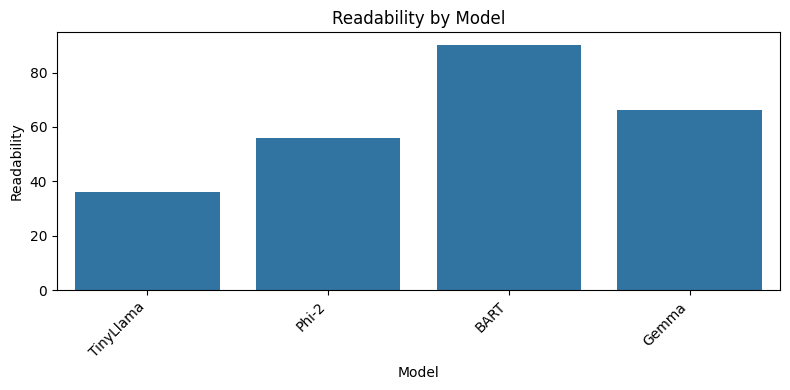

In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import pandas as pd, time

# --- Model Choices ---
abstractive_model_choices = {
    "TinyLlama": "tinyllama",
    "Phi-2": "phi",
    "BART": "bart",
    "Gemma": "gemma"
}
extractive_model_choices = {
    "TextRank": "textrank"
}

metrics_history_specific = []

# --- UI Widgets ---
header_specific = widgets.HTML(
    "<h2> Section B: Summarize with Specific Models</h2>"
    "<p>Paste text, choose summarization type, and select models to run.</p>"
)
prompt_input_specific = widgets.Textarea(
    placeholder="Paste your text here to summarize...",
    layout={"height": "200px", "width": "99%"}
)
summary_type_specific = widgets.RadioButtons(
    options=["Abstractive", "Extractive"], value="Abstractive", description="Type:"
)
model_checkboxes_out = widgets.Output()
checkboxes = {}
generate_button_specific = widgets.Button(
    description="🚀 Generate Summaries", button_style="primary", icon="cogs"
)
clear_button_specific = widgets.Button(
    description="🧹 Clear Outputs", button_style="warning", icon="trash"
)

# --- Outputs ---
summary_output_specific = widgets.Output(
    layout={"height": "400px", "border": "1px solid #ccc", "padding": "10px", "overflow": "scroll"}
)
metrics_table_output_specific = widgets.Output()
bar_plot_output_specific = widgets.Output()
radar_plot_output_specific = widgets.Output()

output_accordion_specific = widgets.Accordion(
    children=[metrics_table_output_specific, bar_plot_output_specific, radar_plot_output_specific]
)
output_accordion_specific.set_title(0, "📊 Metrics Table")
output_accordion_specific.set_title(1, "📈 Bar Charts")
output_accordion_specific.set_title(2, "✨ Radar Plot")

# --- Helper: Update Checkboxes ---
def update_checkboxes(s_type):
    global checkboxes
    checkboxes = {}
    choices = abstractive_model_choices if s_type == "Abstractive" else extractive_model_choices
    with model_checkboxes_out:
        model_checkboxes_out.clear_output(wait=True)
        for name, key in choices.items():
            checkboxes[key] = widgets.Checkbox(value=True, description=name)
        display(widgets.VBox(list(checkboxes.values())))

# --- Summarization Functions ---
def summarize_abstractive(text, model_key):
    """Summarizes text using an abstractive model."""
    model_info = MODELS.get(model_key)
    if not model_info:
        return f"Error: Model '{model_key}' not found."

    if model_key == 'bart':
        # BART uses a pipeline directly
        return model_info['summarizer'](text, max_length=120, min_length=40, do_sample=False)[0]['summary_text']
    else:
        # Other models use tokenizer and model directly
        tokenizer = model_info['tokenizer']
        model = model_info['model']

        if model_key == 'tinyllama':
            chat = [{"role": "user", "content": f"Summarize this text concisely:\n\n{text}"}]
            prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
        elif model_key == 'phi':
             prompt = f"Instruct: Summarize the following text concisely.\n{text}\nOutput:"
        elif model_key == 'gemma':
             prompt = f"Summarize the following text concisely and clearly:\n\n{text}"
        else:
            prompt = f"Summarize the following text:\n\n{text}" # Default prompt

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=200)
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Post-processing for specific models if needed
        if model_key == 'phi' and "Output:" in decoded:
             decoded = decoded.split("Output:")[1].strip()
        elif model_key == 'tinyllama':
             # Assuming the response starts after the prompt for TinyLlama
             decoded = tokenizer.decode(outputs[0][len(inputs["input_ids"][0]):], skip_special_tokens=True)


        return decoded

def summarize_extractive(text, model_key):
    """Summarizes text using an extractive model."""
    if model_key == "textrank":
        # Use the imported textrank_summarizer
        # You might want to adjust the ratio or number of sentences here
        return textrank_summarizer.summarize(text, ratio=0.3) # Adjust ratio as needed
    else:
        return f"Error: Extractive model '{model_key}' not supported."

# --- Metrics Calculation (Assuming calculate_metrics, create_bar_charts, create_radar_chart are defined elsewhere) ---
# Placeholder functions - replace with your actual implementations
def calculate_metrics(summary, original_text, proc_time):
    """Calculates ROUGE, Semantic Similarity, Readability, and Compression."""
    # This is a placeholder. Replace with the actual metric calculation logic.
    # You'll need to import rouge_scorer, SentenceTransformer, textstat, etc.
    try:
        readability = textstat.flesch_reading_ease(summary)
    except:
        readability = 0 # Handle potential errors with textstat

    try:
        compression = round((1 - len(summary) / len(original_text)) * 100, 2) if len(original_text) > 0 else 0
    except:
        compression = 0 # Handle potential division by zero

    # Placeholder for other metrics
    return {
        "Readability": readability,
        "Compression (%)": compression,
        "Processing Time (s)": round(proc_time, 2),
        # Add placeholders for ROUGE and Semantic Similarity if you want to include them
        "ROUGE-1 F1": 0,
        "Semantic Similarity": 0,
    }

def create_bar_charts(df):
    """Generates bar charts for metrics."""
    # This is a placeholder. Replace with your actual bar chart generation logic.
    # You'll need matplotlib.pyplot and seaborn
    import matplotlib.pyplot as plt
    import seaborn as sns
    import io

    if df.empty:
        return HTML("<p>No data to plot yet.</p>")

    metrics_to_plot = ["Readability", "Compression (%)", "Processing Time (s)", "ROUGE-1 F1", "Semantic Similarity"]
    plot_html = ""

    for metric in metrics_to_plot:
        if metric in df.columns:
            plt.figure(figsize=(8, 4))
            sns.barplot(x="Model", y=metric, data=df)
            plt.title(f"{metric} by Model")
            plt.ylabel(metric)
            plt.xlabel("Model")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()

            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            img_base64 = base66.b64encode(buf.read()).decode('utf-8')
            plt.close()
            plot_html += f'<img src="data:image/png;base64,{img_base64}"/><br>'

    return HTML(plot_html)


def create_radar_chart(df):
    """Generates a radar chart for normalized metrics."""
    # This is a placeholder. Replace with your actual radar chart generation logic.
    # You'll need matplotlib.pyplot and numpy
    import matplotlib.pyplot as plt
    import numpy as np
    import io
    import base64

    if df.empty:
        return HTML("<p>No data to plot yet.</p>")

    # Select metrics for the radar chart (choose metrics that make sense for comparison)
    radar_metrics = ["Readability", "Compression (%)", "Processing Time (s)", "ROUGE-1 F1", "Semantic Similarity"]

    # Normalize data (simple min-max scaling)
    df_normalized = df[radar_metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0)
    df_normalized['Model'] = df['Model']

    categories = radar_metrics
    N = len(categories)

    # What angle each axis will start at
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Complete the circle

    plot_html = ""

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Draw one axe per instance and add labels
    plt.xticks(angles[:-1], categories, color='grey', size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.50", "0.75", "1.00"], color="grey", size=7)
    plt.ylim(0, 1)

    # Plot data and add a line plot per model
    for index, row in df_normalized.iterrows():
        values = row[categories].tolist()
        values += values[:1] # Complete the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Model'])
        ax.fill(angles, values, alpha=0.4) # Fill area

    plt.title("Normalized Metrics Comparison", size=12, color='grey', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()
    plot_html += f'<img src="data:image/png;base64,{img_base64}"/>'

    return HTML(plot_html)


# --- Event: Generate Summaries ---
def on_generate_button_clicked_specific(b):
    generate_button_specific.disabled = True
    generate_button_specific.description = "Processing..."
    original_text = prompt_input_specific.value.strip()
    s_type = summary_type_specific.value
    s_keys = [key for key, cb in checkboxes.items() if cb.value]

    if not original_text or not s_keys:
        with summary_output_specific:
            clear_output()
            print("⚠️ Please enter text and select at least one model.")
        generate_button_specific.disabled = False
        generate_button_specific.description = "🚀 Generate Summaries"
        return

    with summary_output_specific:
        clear_output()
        display(HTML(f"<hr><h2>Processing Pasted Text ({s_type})</h2>"))

    current_metrics = [] # Store metrics for this run

    for model_key in s_keys:
        model_name = (
            [k for k, v in abstractive_model_choices.items() if v == model_key]
            + [k for k, v in extractive_model_choices.items() if v == model_key]
        )[0]

        with summary_output_specific:
            print(f"⏳ Summarizing with {model_name}...")

        start_time = time.time()
        try:
            summary = (
                summarize_abstractive(original_text, model_key)
                if s_type == "Abstractive"
                else summarize_extractive(original_text, model_key)
            )
            proc_time = time.time() - start_time

            with summary_output_specific:
                display(HTML(f"<h3>Summary from <b>{model_name}</b></h3><p>{summary}</p>"))

            metrics = calculate_metrics(summary, original_text, proc_time)
            metrics.update({"Model": model_name, "File": "Pasted Text", "Type": s_type})
            current_metrics.append(metrics) # Add to current run's metrics

        except Exception as e:
            with summary_output_specific:
                print(f"❌ Error summarizing with {model_name}: {e}")
            # Optionally add an entry for the failed model with error info
            metrics = {"Model": model_name, "File": "Pasted Text", "Type": s_type, "Error": str(e)}
            current_metrics.append(metrics) # Add error entry

    # Append current run's metrics to history
    metrics_history_specific.extend(current_metrics)


    # --- Display Metrics ---
    if current_metrics: # Only update if there were successful runs
        df = pd.DataFrame(metrics_history_specific) # Use the full history
        with metrics_table_output_specific:
            metrics_table_output_specific.clear_output(wait=True)
            display(df)

        with bar_plot_output_specific:
            bar_plot_output_specific.clear_output(wait=True)
            display(create_bar_charts(df))

        with radar_plot_output_specific:
            radar_plot_output_specific.clear_output(wait=True)
            display(create_radar_chart(df))
    else:
         with metrics_table_output_specific:
            metrics_table_output_specific.clear_output(wait=True)
            print("No successful summaries to display metrics.")
         with bar_plot_output_specific:
            bar_plot_output_specific.clear_output(wait=True)
         with radar_plot_output_specific:
            radar_plot_output_specific.clear_output(wait=True)


    generate_button_specific.disabled = False
    generate_button_specific.description = "🚀 Generate Summaries"

# --- Event: Clear All ---
def on_clear_button_clicked_specific(b):
    global metrics_history_specific
    metrics_history_specific = []
    summary_output_specific.clear_output()
    metrics_table_output_specific.clear_output()
    bar_plot_output_specific.clear_output()
    radar_plot_output_specific.clear_output()
    prompt_input_specific.value = ""
    with summary_output_specific:
        print("🧹 All outputs cleared.")

# --- Event: Summary Type Change ---
def on_summary_type_change_specific(change):
    update_checkboxes(change.new)

generate_button_specific.on_click(on_generate_button_clicked_specific)
clear_button_specific.on_click(on_clear_button_clicked_specific)
summary_type_specific.observe(on_summary_type_change_specific, names="value")

# --- Assemble and Display UI ---
input_controls_specific = widgets.VBox(
    [
        prompt_input_specific,
        summary_type_specific,
        widgets.Label("Select Models:"),
        model_checkboxes_out,
        widgets.HBox([generate_button_specific, clear_button_specific]),
    ],
    layout=widgets.Layout(width="35%", padding="10px", border="1px solid lightgrey", border_radius="5px"),
)

output_area_specific = widgets.VBox(
    [summary_output_specific, output_accordion_specific],
    layout=widgets.Layout(width="65%", padding="10px"),
)

app_specific = widgets.VBox(
    [header_specific, widgets.HBox([input_controls_specific, output_area_specific])]
)

# --- Initialize ---
update_checkboxes("Abstractive")
display(app_specific)